In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ../Optic Disc Detection/

/content/drive/MyDrive/Optic Disc Detection


## Importing Basic required Libraries

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
from time import time
import matplotlib.pyplot as plt

import scipy.misc
!pip install scipy==1.2.2
from skimage.io import imsave
from keras.preprocessing import image
from skimage.transform import rotate, resize
from skimage.measure import label, regionprops

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

import Model_MNet as MNetModel
import Model_DiscSeg as DiscModel
from utils_Mnet import pro_process, BW_img, disc_crop

import warnings
warnings.simplefilter("ignore")


## Preparing data and folders to store proceessed and output data

In [ ]:
DiscROI_size = 400
DiscSeg_size = 640
CDRSeg_size = 400

train_data_type = '.png'
mask_data_type ='.bmp'

PathToData = '../data'

DiscRegion='../DiscRegion/'
PolarImages='../PolarImages/'
SegmentedOpticDisc = '../SegmentationResults_DL/'
SegmentedOpticDisc_DL_Full = '../SegmentationResults_DL_FULL/'

if not os.path.exists(SegmentedOpticDisc):
    os.makedirs(SegmentedOpticDisc)
if not os.path.exists(DiscRegion):
    os.makedirs(DiscRegion)        
if not os.path.exists(PolarImages):
    os.makedirs(PolarImages)   
if not os.path.exists(SegmentedOpticDisc_DL_Full):
    os.makedirs(SegmentedOpticDisc_DL_Full)

## Loading the Models

In [ ]:
TrainingImages = [file for file in os.listdir(PathToData) if file.lower().endswith(train_data_type)]

ODSmodel = DiscModel.DeepModel(size_set=DiscSeg_size)
ODSmodel.load_weights('Mnet_Models/Model_DiscSeg_ORIGA_pretrain.h5')

CupToDiscRatios = MNetModel.DeepModel(size_set=CDRSeg_size)
CupToDiscRatios.load_weights('Mnet_Models/Model_MNet_ORIGA_pretrain.h5')

In [ ]:
!cd ../SegmentationResults_DL_FULL/

/content/drive/MyDrive/Optic Disc Detection/SegmentationResults_DL_FULL


## Performing Optic Disc Segmentation using the model weights 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.0942378044128418   Img number: 1


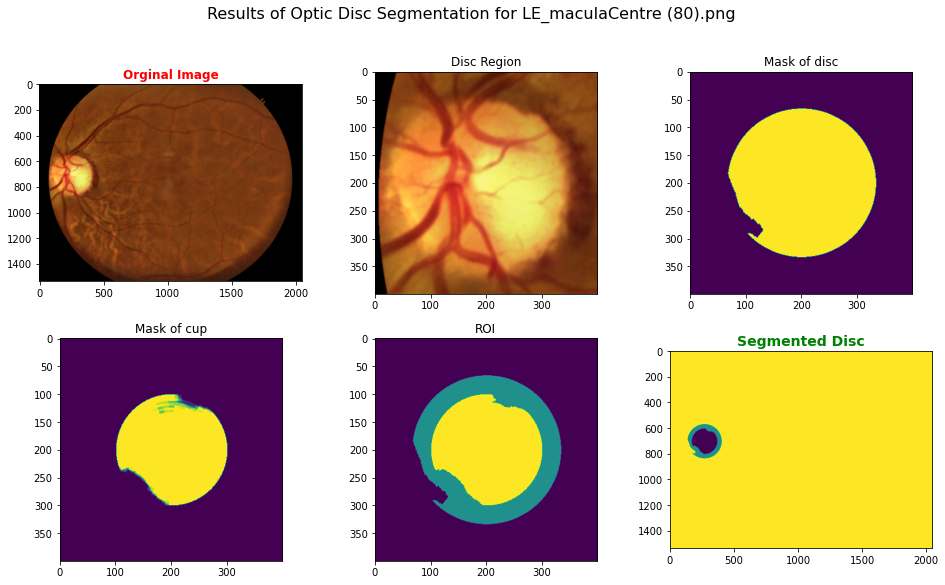

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09306812286376953   Img number: 2


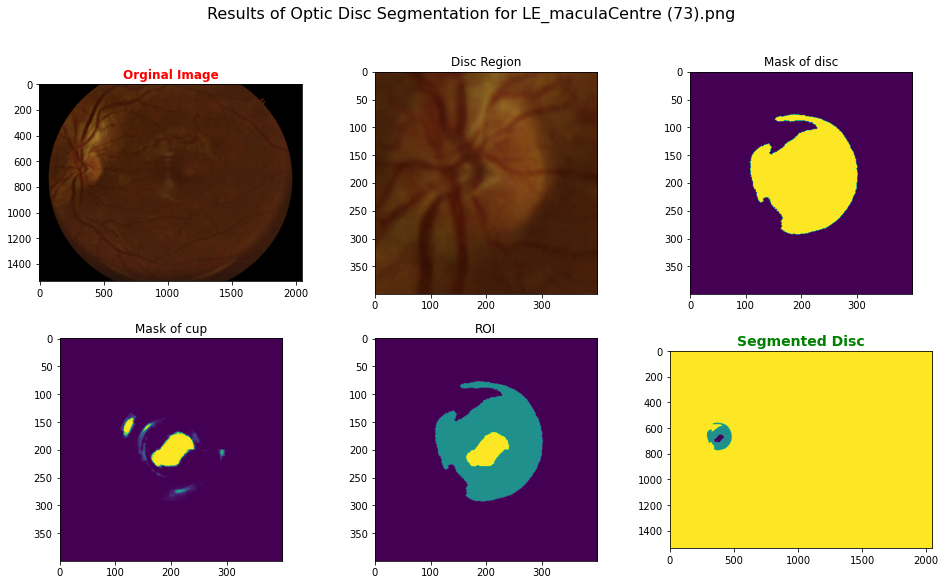

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09100842475891113   Img number: 3


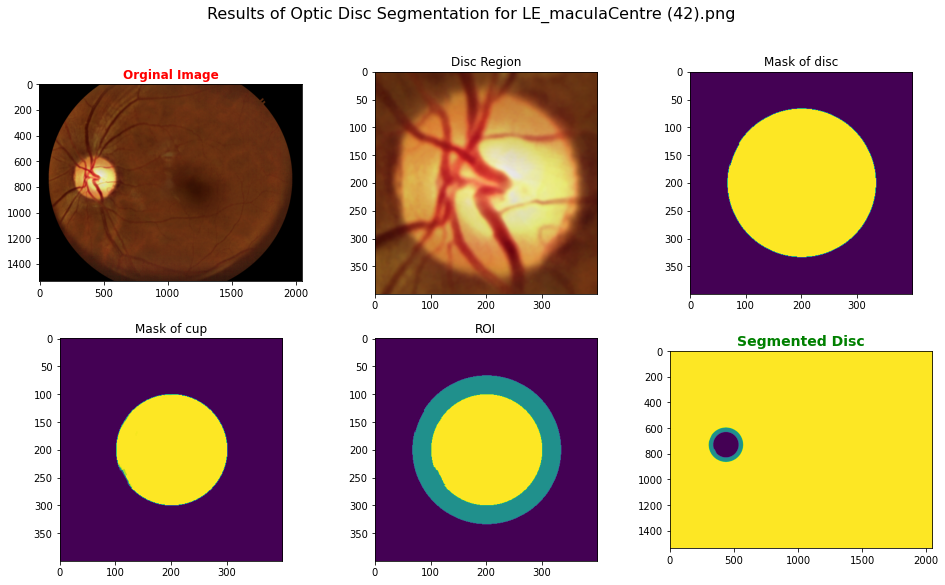

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.093780517578125   Img number: 4


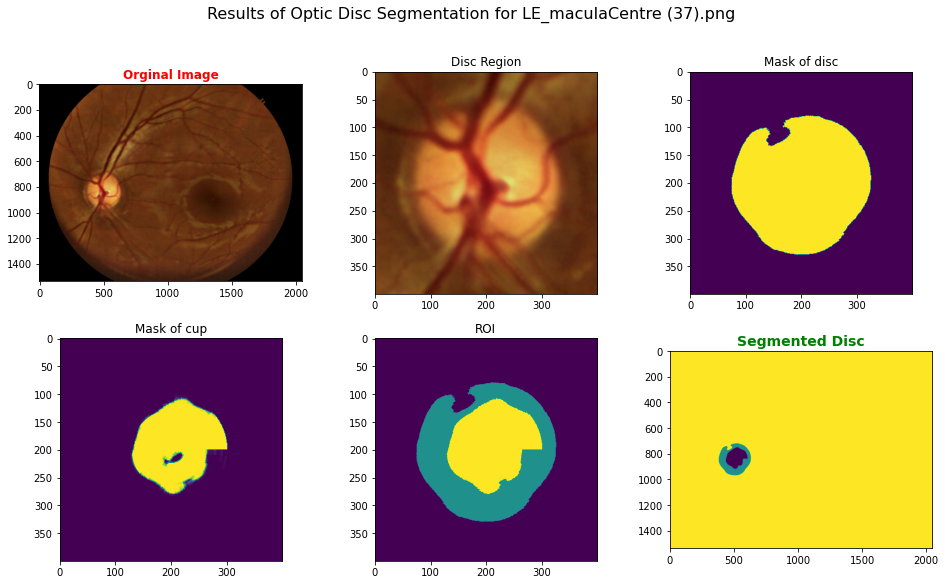

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09286069869995117   Img number: 5


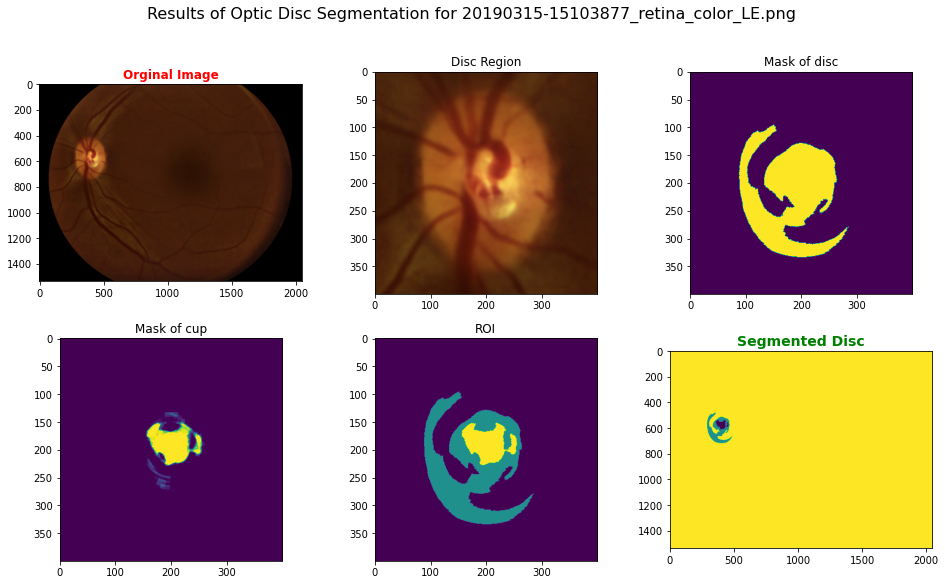

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09315919876098633   Img number: 6


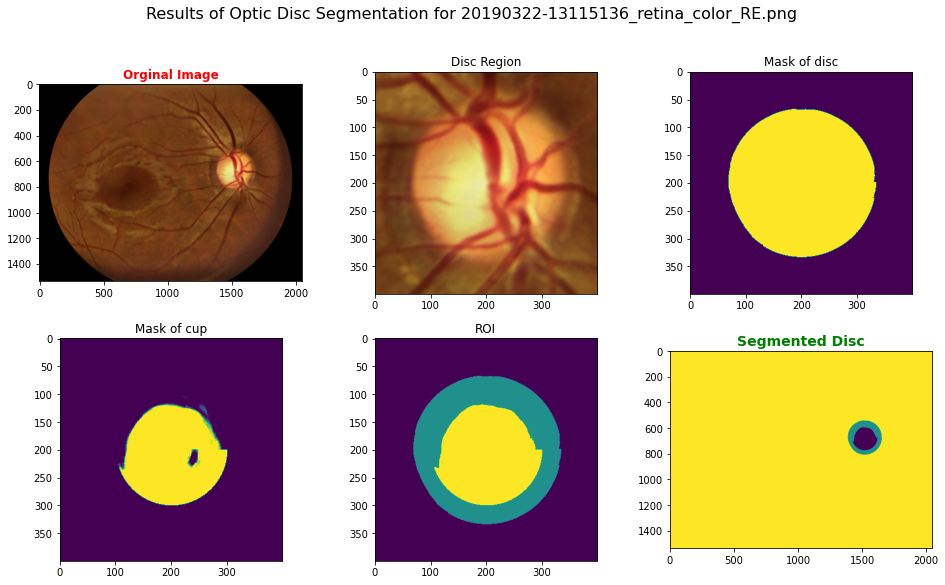

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09713864326477051   Img number: 7


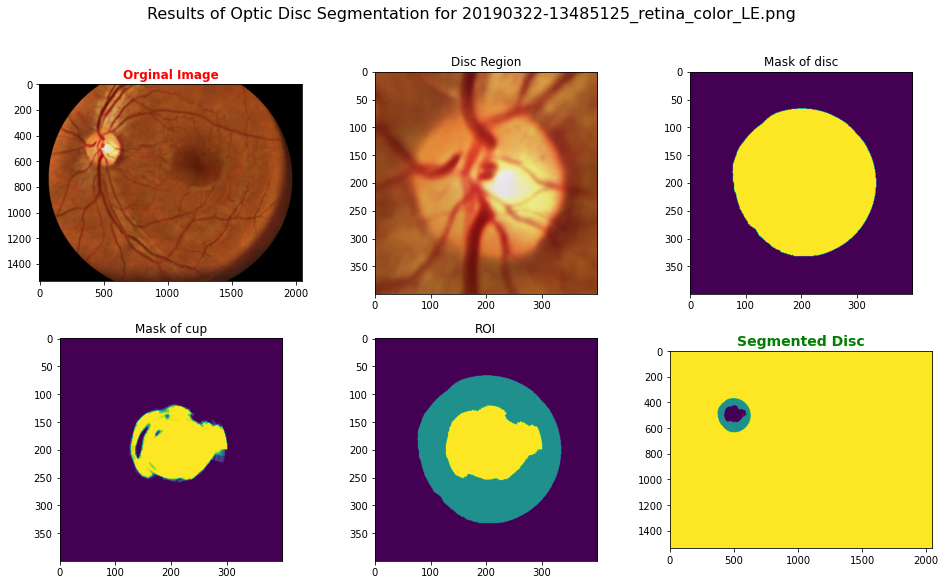

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09508705139160156   Img number: 8


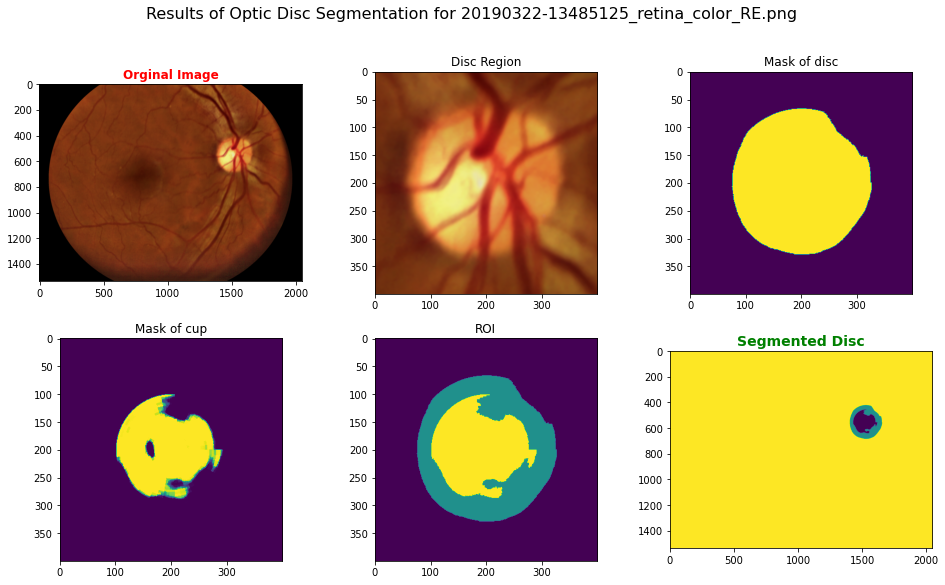

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09096884727478027   Img number: 9


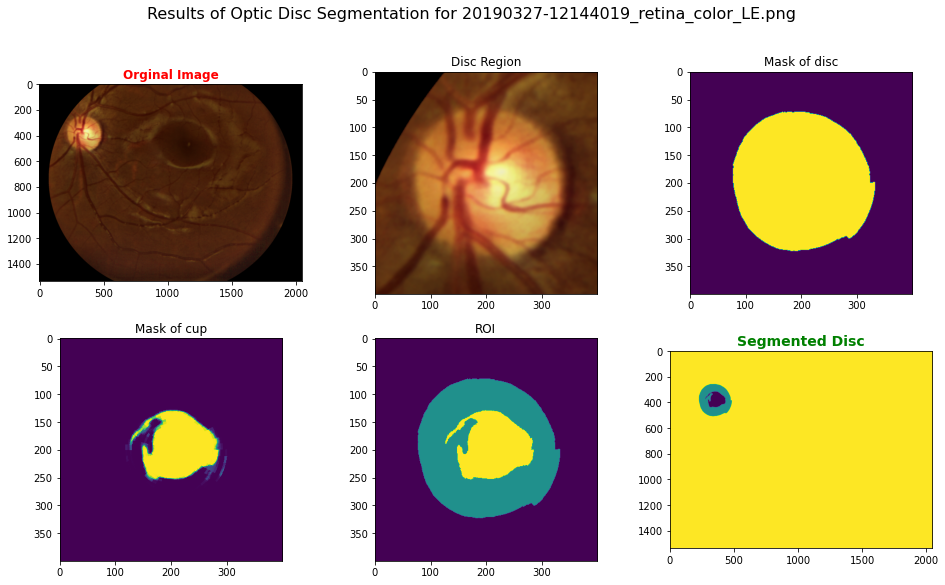

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09121942520141602   Img number: 10


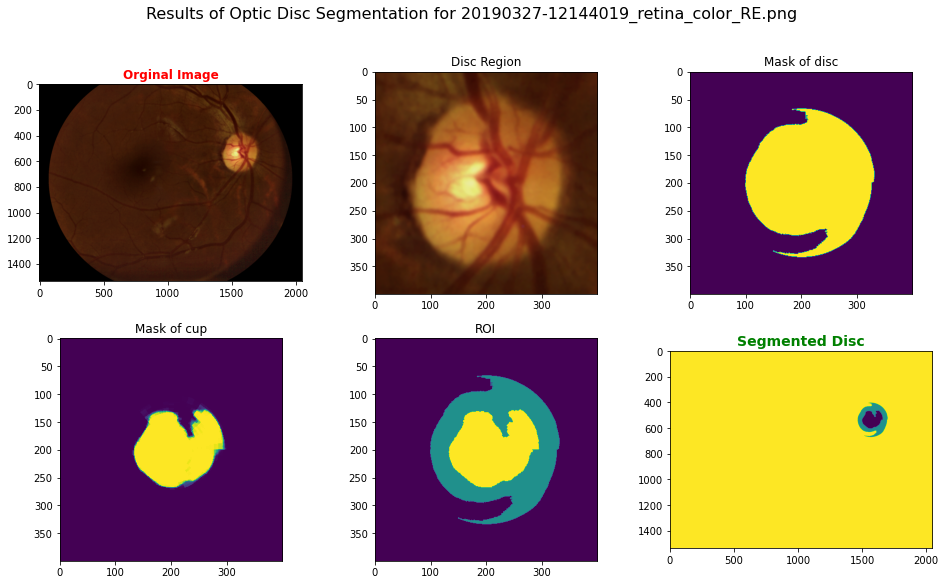

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09203171730041504   Img number: 11


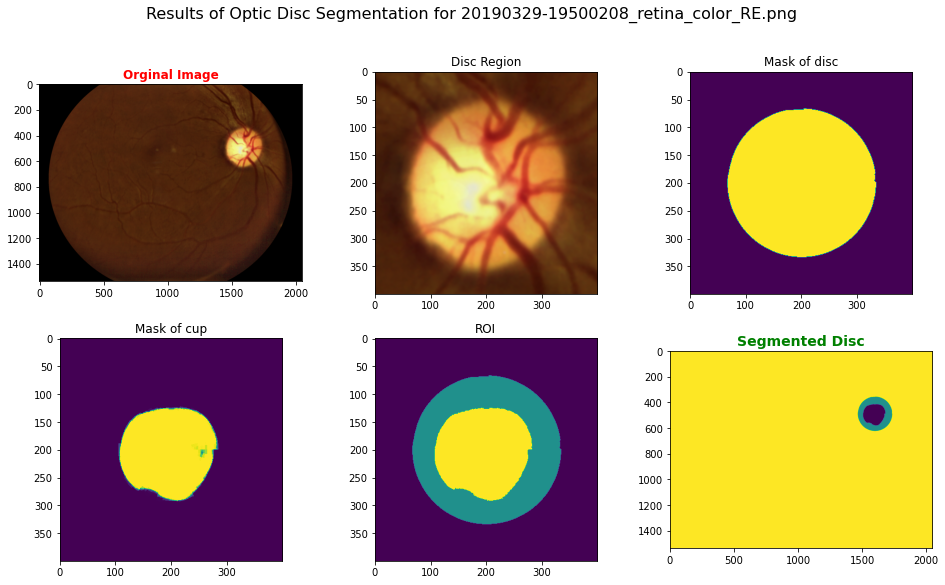

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09176373481750488   Img number: 12


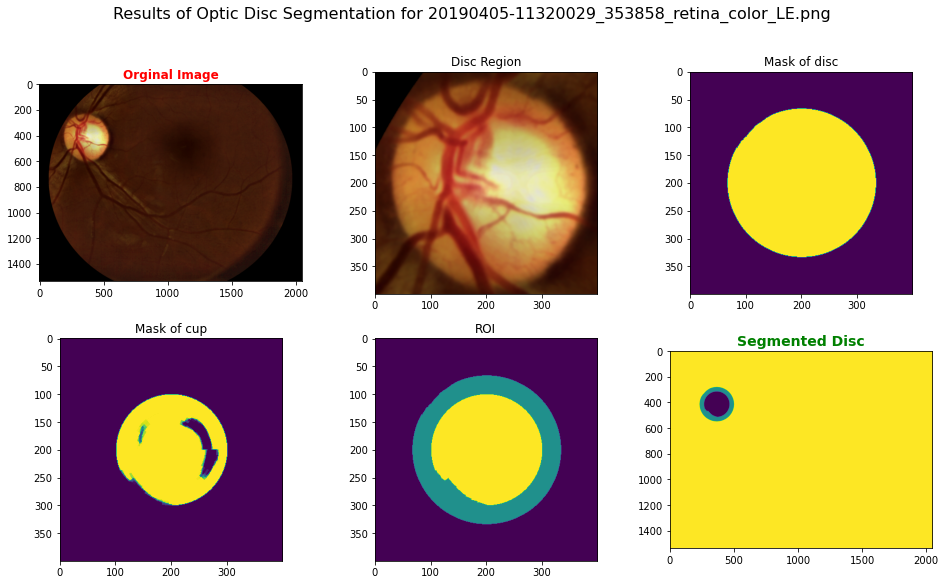

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09753751754760742   Img number: 13


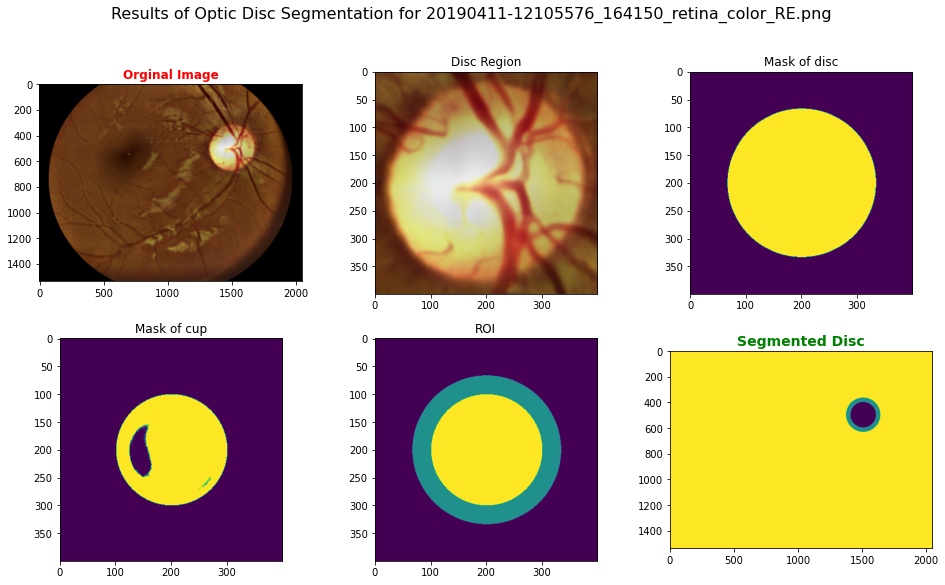

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09302806854248047   Img number: 14


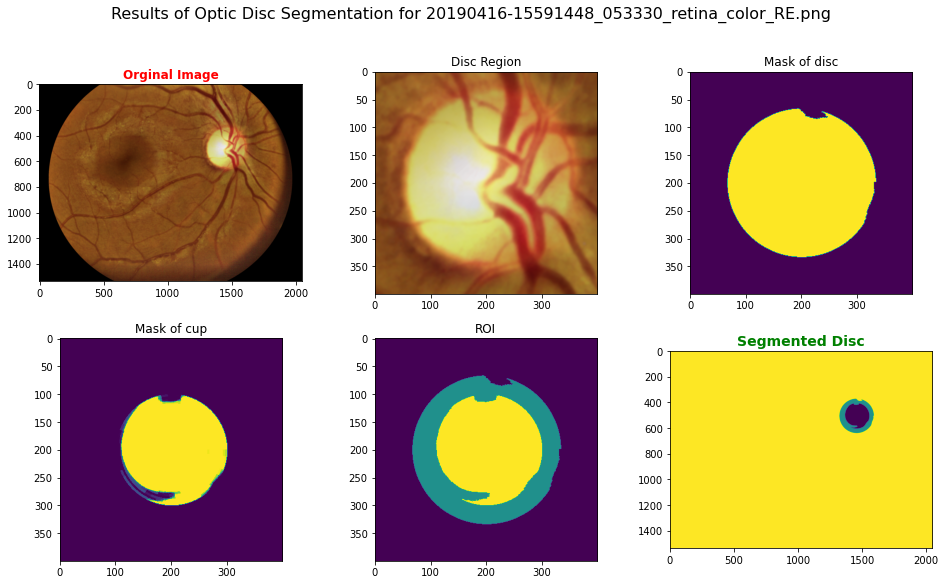

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.0965576171875   Img number: 15


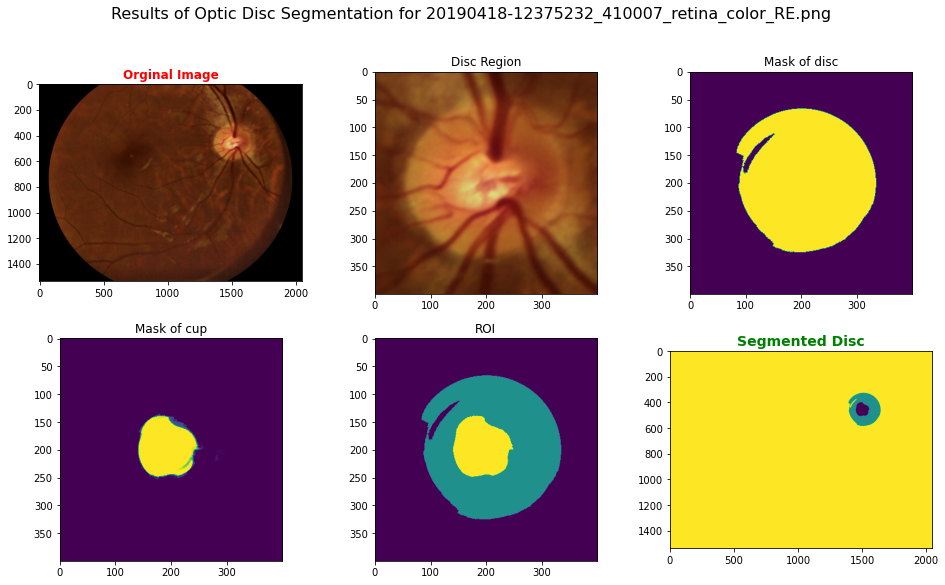

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.0924825668334961   Img number: 16


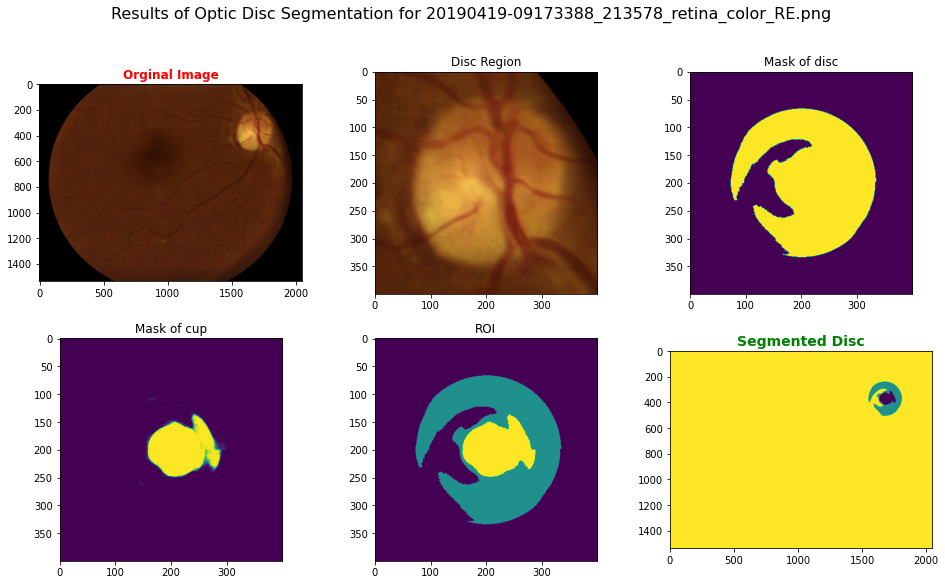

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09403562545776367   Img number: 17


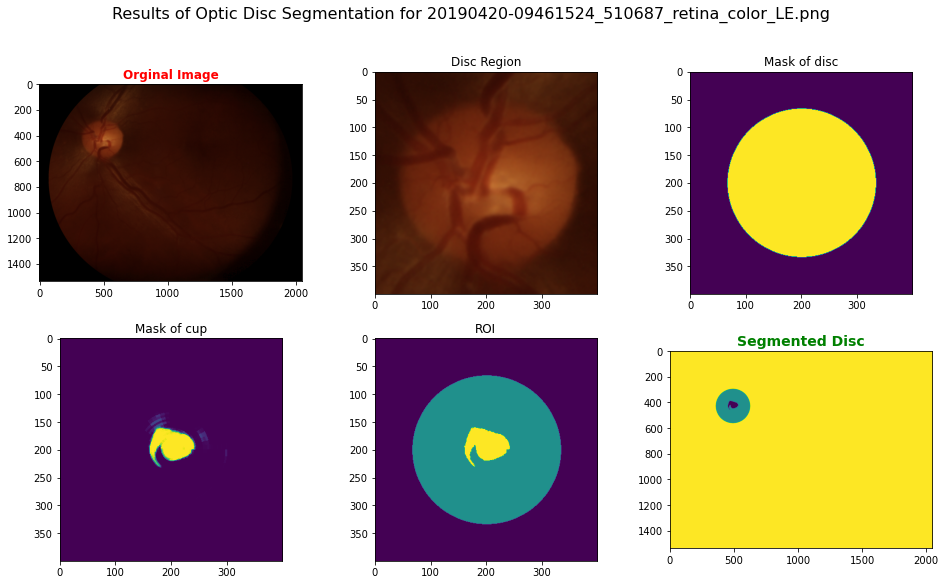

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.0930032730102539   Img number: 18


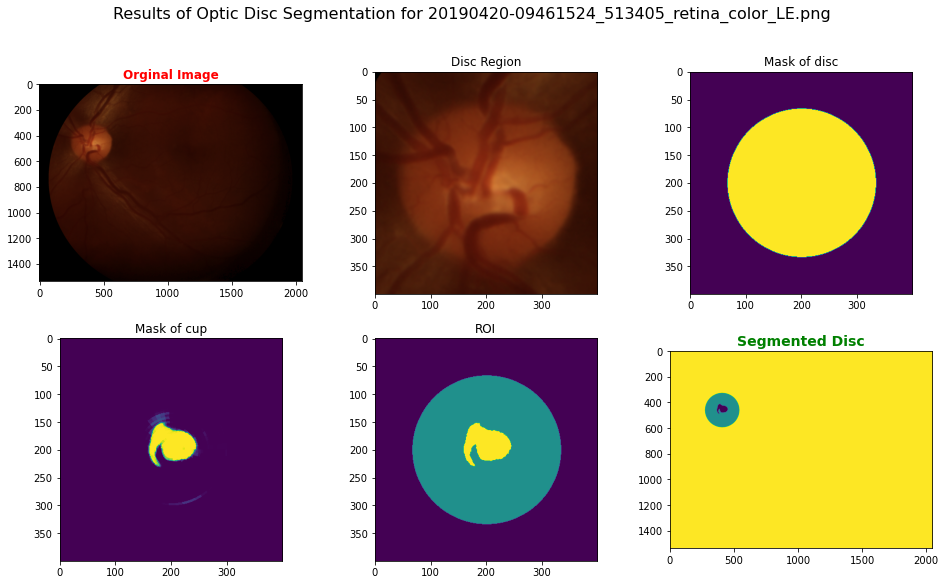

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09481692314147949   Img number: 19


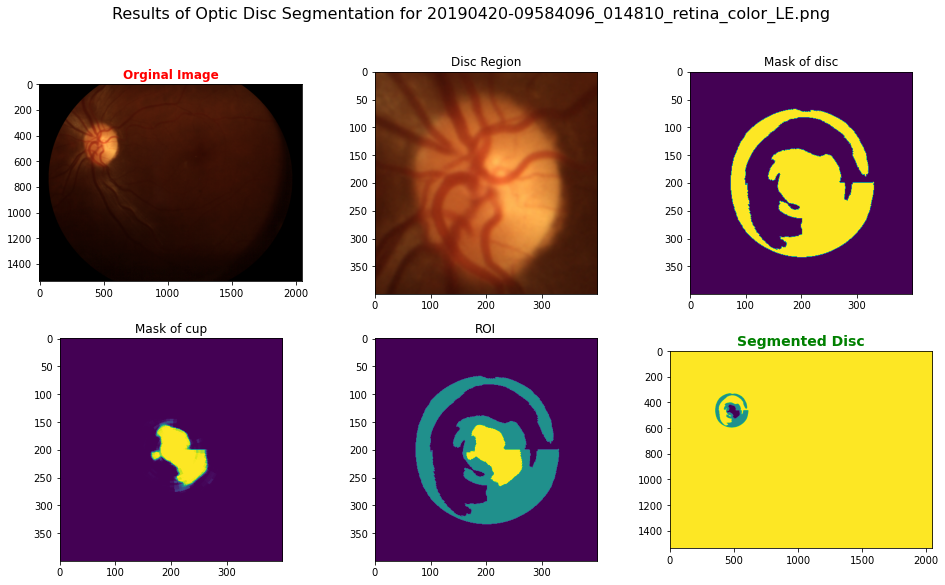

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.0955495834350586   Img number: 20


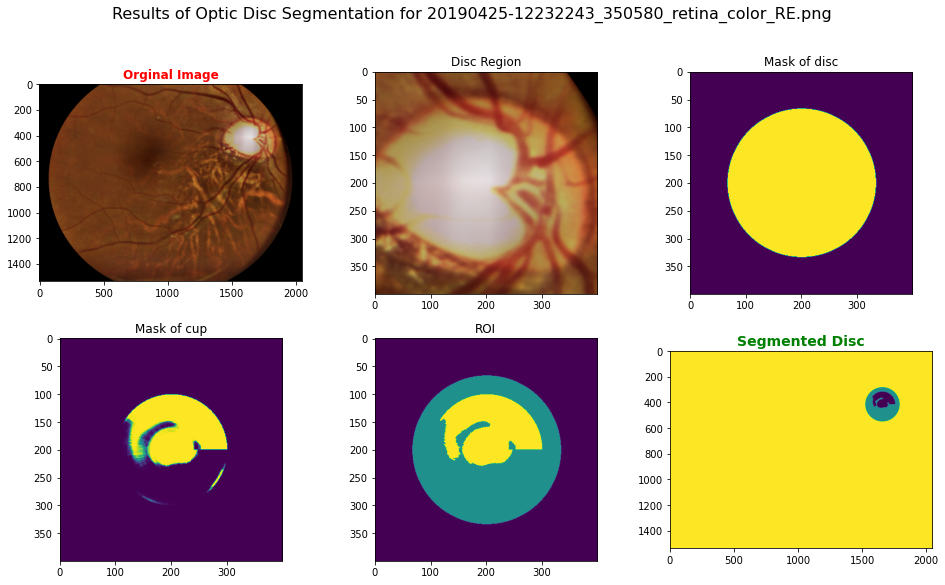

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09627008438110352   Img number: 21


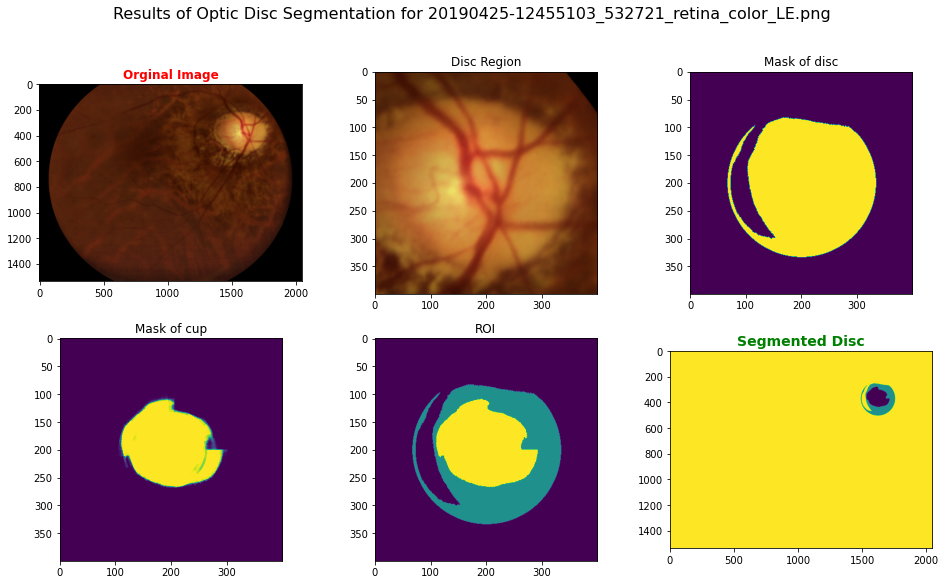

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09354853630065918   Img number: 22


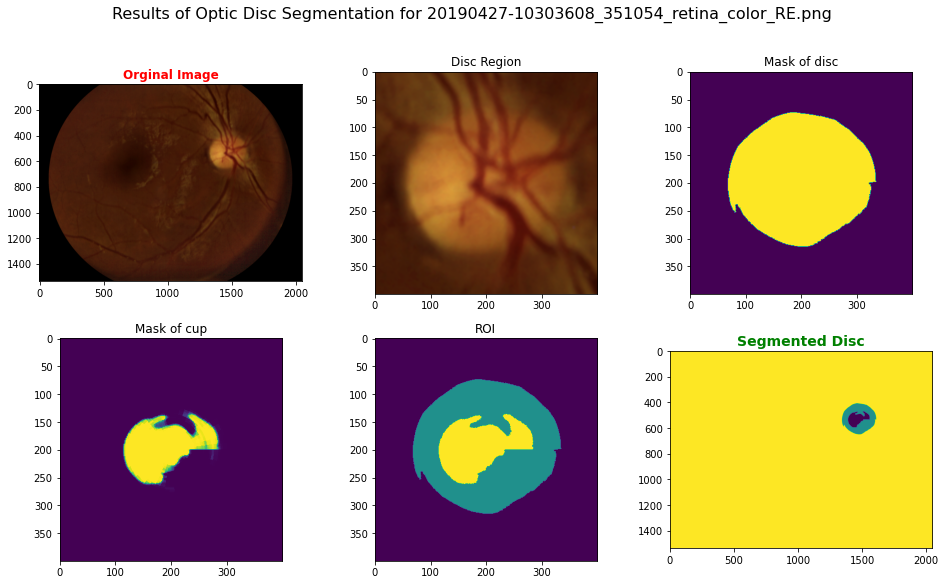

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.10485124588012695   Img number: 23


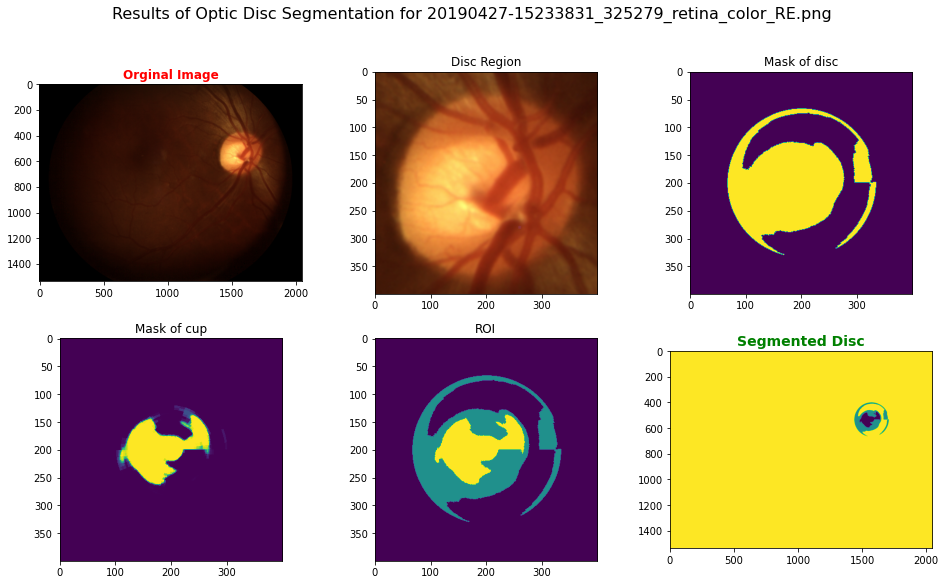

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09200429916381836   Img number: 24


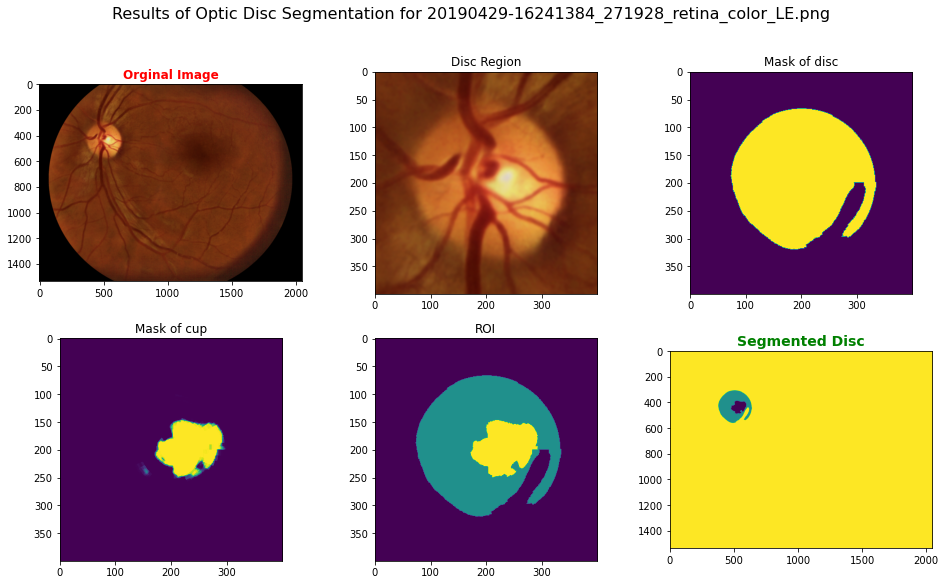

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Run time MNet: 0.09662890434265137   Img number: 25


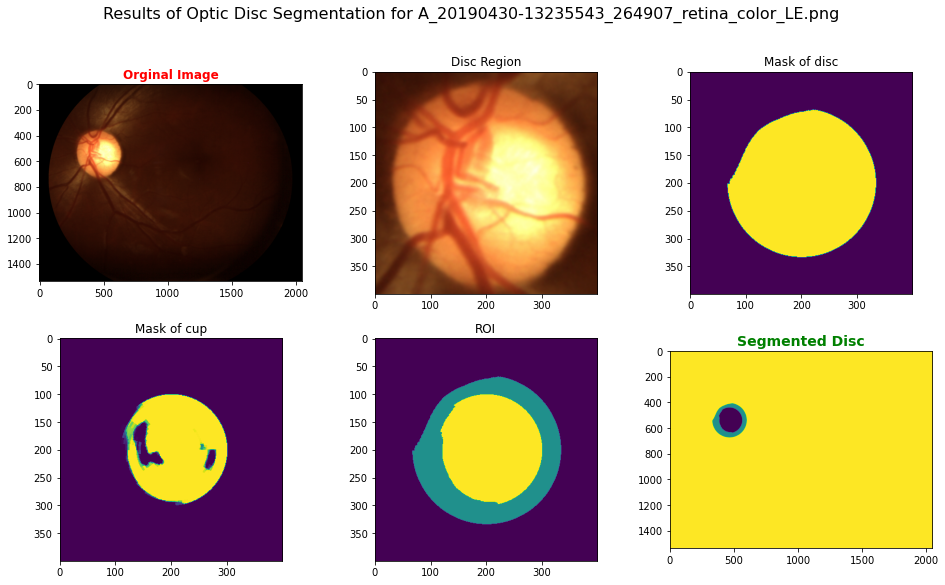

In [ ]:
for imageid in range(0, len(TrainingImages)):
    
    TempText = [elt.strip() for elt in TrainingImages[imageid].split(',')]
    print("------"*70)
    OrgImage = np.asarray(image.load_img(PathToData + TempText[0]))
    
    # Disc localisation by U-Net
    tempOrgImg = resize(OrgImage, (DiscSeg_size, DiscSeg_size, 3)) 

    tempOrgImg = np.reshape(tempOrgImg, (1,) + tempOrgImg.shape)*255

    #Predicting the probabilities of regions using the pre trained model
    [prob_6, prob_7, prob_8, prob_9, prob_10] = ODSmodel.predict([tempOrgImg]) 
    OrgImage_disc_map = BW_img(np.reshape(prob_10, (DiscSeg_size, DiscSeg_size)), 0.5)   
    regions = regionprops(label(OrgImage_disc_map))

    
    C_x = int(regions[0].centroid[0] * OrgImage.shape[0] / DiscSeg_size)
    C_y = int(regions[0].centroid[1] * OrgImage.shape[1] / DiscSeg_size)
    OrgImage_disc_region, err_coord, crop_coord = disc_crop(OrgImage, DiscROI_size, C_x, C_y)

    
    # Disc segmentation by M-Net

    run_time_start = time()
    # Converting cartesian co-ordinates to polar co-ordinates i.e Polar Tranformations
    OrgImage_Disc_flat = rotate(cv2.linearPolar(OrgImage_disc_region, (DiscROI_size/2, DiscROI_size/2), DiscROI_size/2, cv2.WARP_FILL_OUTLIERS), -90)
    
    
    temp_img = pro_process(OrgImage_Disc_flat, CDRSeg_size)
    temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
    [prob_6, prob_7, prob_8, prob_9, prob_10] = CupToDiscRatios.predict(temp_img)
    
    run_time_end = time()

    # Extracting the mask
    ProbabilisticMask = np.reshape(prob_10, (prob_10.shape[1], prob_10.shape[2], prob_10.shape[3]))
    disc_map = scipy.misc.imresize(ProbabilisticMask[:, :, 0], (DiscROI_size, DiscROI_size))

    cup_map = scipy.misc.imresize(ProbabilisticMask[:, :, 1], (DiscROI_size, DiscROI_size))

    disc_map[-round(DiscROI_size / 3):, :] = 0
    cup_map[-round(DiscROI_size / 2):, :] = 0
    DiskMask = cv2.linearPolar(rotate(disc_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                      DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)



    CupMask = cv2.linearPolar(rotate(cup_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                     DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
    

    
    DiskMask = np.array(BW_img(DiskMask, 0.5), dtype=int)


    

    print(' Run time MNet: ' + str(run_time_end - run_time_start) + '   Img number: ' + str(imageid + 1))

    # Save mask
    ROIimage = np.array(BW_img(DiskMask, 0.5), dtype=int) + np.array(BW_img(CupMask, 0.5), dtype=int)
     
    

    ResultImage = np.zeros((OrgImage.shape[0],OrgImage.shape[1]), dtype=int);
    ResultImage[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ] = ROIimage[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3], ];



    imsave(DiscRegion+TempText[0],OrgImage_disc_region)
      
    imsave(PolarImages+TempText[0],OrgImage_Disc_flat)
    
    ResultImage=ResultImage /ResultImage.max()
    ResultImage=255*ResultImage
    ResultImage=ResultImage.astype(np.uint8)
    ResultImage[ResultImage==255]=200
    ResultImage[ResultImage==0]=255   
    ResultImage[ResultImage==200]=0   
    ResultImage[(ResultImage<200) & (ResultImage>0)]=128  
    imsave(SegmentedOpticDisc+TempText[0],(ResultImage))   


    fig, ax = plt.subplots(2,3, figsize=(16,9), facecolor=(1, 1, 1))
    fig.set_facecolor('white')
    fig.suptitle("Results of Optic Disc Segmentation for %s" %(TempText[0]), size=16)
    ax[0,0].imshow(OrgImage)
    ax[0,1].imshow(OrgImage_disc_region)
    ax[0,2].imshow(DiskMask)
    ax[1,0].imshow(CupMask)
    ax[1,1].imshow(ROIimage)
    ax[1,2].imshow(ResultImage)
    ax[0,0].set_title('Orginal Image', color='red', fontweight='bold')
    ax[0,1].set_title('Disc Region')
    ax[0,2].set_title('Mask of disc')
    ax[1,0].set_title('Mask of cup') 
    ax[1,1].set_title('ROI')
    ax[1,2].set_title('Segmented Disc', fontweight='bold', size=14, color='green')
    plt.show()
    
    fig.savefig('ODS_DL_{0}.jpg'.format(TempText[0][0:-4]))
    